# **Notebook 5: Modeling & Evaluation**

## Objectives

* Fit and evaluate a regression model to predict prices on houses.

## Inputs

* outputs/datasets/collection/house_prices_records.csv
* Instructions on which features to use for data cleaning and feature engineering can be found in respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/housing'

# Step 1: Load data

Here we load the dataset and separate the target variable ('y') from the predictor variables ('X').



In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv"))

# Separate predictors and target
X = df.drop(['SalePrice'], axis=1)
y = df['SalePrice']

print(X.shape)
X.head(3)

(1460, 23)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,8450,65.0,196.0,61,5,7,856,0.0,2003,2003
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,9600,80.0,0.0,0,8,6,1262,NaN,1976,1976
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,11250,68.0,162.0,42,5,7,920,NaN,2001,2002


---

# Step 2: ML Pipeline with all data

## ML pipeline for Data Cleaning and Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.selection import DropFeatures

def PipelineDataCleaningAndFeatureEngineering():
    from sklearn.base import BaseEstimator, TransformerMixin

    class ConvertToInt64(BaseEstimator, TransformerMixin):
        def __init__(self, columns):
            self.columns = columns

        def fit(self, X, y=None):
            return self

        def transform(self, X):
            for col in self.columns:
                X[col] = X[col].astype('Int64')
            return X

    pipeline_base = Pipeline([
        
        ("ConvertToInt64", ConvertToInt64(columns=['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea'])),
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        
        ("MedianImputer", MeanMedianImputer(imputation_method='median', 
                                             variables=['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea'])),
        
        ("CategoricalImputer", CategoricalImputer(variables=['BsmtFinType1', 'GarageFinish'])),
        
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        
        ("YeoJohnsonTransformer", YeoJohnsonTransformer(variables=['1stFlrSF', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage'])),
        
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

    ])

    return pipeline_base

PipelineDataCleaningAndFeatureEngineering()



Pipeline(steps=[('ConvertToInt64',
                 ConvertToInt64(columns=['2ndFlrSF', 'BedroomAbvGr',
                                         'GarageYrBlt', 'LotFrontage',
                                         'MasVnrArea'])),
                ('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('MedianImputer',
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'GarageYrBlt', 'LotFrontage',
                                              'MasVnrArea'])),
                ('CategoricalImputer',
                 Categ...
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransforme

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

def PipelineReg(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Custom Class for Hyperparameter Optimisation

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineReg(self.models[key])  # changed this to regression
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train and Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(1168, 23) (1168,) (292, 23) (292,)


## Extra step

In the cell below, we are manually converting selected numerical columns to integer type after splitting the data, because that conversion step is not included in our pipeline (see notebook 1 for details). This step is separate from the data cleaning and transformation steps that will be applied during the pipeline fitting process.

In [ ]:
# Convert selected columns in the train set to Int64
cols_to_convert_records = ['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea']
for col in cols_to_convert_records:
    X_train[col] = X_train[col].astype('Int64')

# Do the same in the test set
for col in cols_to_convert_records:
    X_test[col] = X_test[col].astype('Int64')

We also do conversions from float to int type in the dataset inherited_df. However, the type conversions for inherited_df will be done separately because they are different from the ones used for records_df.

In [ ]:
# First we load inherited_df dataset
inherited_df = pd.read_csv("outputs/datasets/future_data/inherited_houses.csv")

# Then we drop columns 'EnclosedPorch' and 'WoodDeckSF' just like the main data
inherited_df = inherited_df.drop(['EnclosedPorch', 'WoodDeckSF'], axis=1)

# We perform data type conversion
cols_to_convert_inherited = ['BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GarageYrBlt', 'TotalBsmtSF']
for col in cols_to_convert_inherited:
    inherited_df[col] = inherited_df[col].astype('int64')

# Note that 'GarageYrBlt' is the only variable present in both lists 
# because it's the only one that needs to be converted to an integer in both dataframes.

Note: we do not handle target imbalance at this point since the target in this project is a continuous variable. It's possible to come back to this step later and add a cell to normalize the distribution of the target variable to fit the model better.

In [ ]:
print(X_train.columns)

In [ ]:
X_train.dtypes

## Fit pipeline

In [9]:
# Fit the PipelineDataCleaningAndFeatureEngineering pipeline
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1168, 17) (292, 17) (1168,) (292,)


## Grid Search CV - Sklearn

Use standard hyperparameters to find most suitable algorithm

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models_quick_search = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
    "LGBMRegressor": LGBMRegressor(random_state=0),
}

params_quick_search = {
    "RandomForestRegressor": {},
    "GradientBoostingRegressor": {},
    "AdaBoostRegressor": {},
    "XGBRegressor": {},
    "LGBMRegressor": {},
}


And then Quick GridSearch CV

In [12]:
from sklearn.metrics import make_scorer, mean_absolute_error

scorer = make_scorer(mean_absolute_error, greater_is_better=True)

search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring=scorer, n_jobs=-1, cv=5)



Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for LGBMRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
3,XGBRegressor,28968.361353,31342.340933,33345.455429,1794.742211
2,AdaBoostRegressor,26700.207193,30494.340606,33391.792249,2408.047289
0,RandomForestRegressor,24012.150233,27885.798355,30478.201242,2182.091385
4,LGBMRegressor,18903.899719,23704.651367,27324.763193,2944.679209
1,GradientBoostingRegressor,20882.497828,23275.533492,26017.738008,1798.470621


Based on the mean MAE scores, the LGBMRegressor model performed the best, followed by the GradientBoostingRegressor model. 

### Do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

models_search = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "RandomForestRegressor": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 6, None],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
    },
    "GradientBoostingRegressor": {
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 6],
        'model__n_estimators': [100, 200],
    },
}


Extensive GridSearch CV

In [16]:
from sklearn.metrics import mean_absolute_error, make_scorer

scorer = make_scorer(mean_absolute_error, greater_is_better=True)

search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring=scorer, n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Check results

Here we get a summary table showing the results from the GridSearchCV operation. It includes the mean_score, which we can use to compare the performance of different hyperparameters configurations. The one with the highest (or lowest, if your metric is an error/loss to be minimized) mean_score would be the optimal choice.

Keep in mind that the score here is the mean_squared_error with greater_is_better=False, so the model configuration with the most negative mean score is the best one, as it signifies the lowest mean squared error.

In [17]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate
24,GradientBoostingRegressor,29991.83607,32688.374617,35755.05786,2217.318945,3,NaN,NaN,100,0.01
26,GradientBoostingRegressor,27865.149816,30211.692968,32891.56544,2228.002804,6,NaN,NaN,100,0.01
0,RandomForestRegressor,26316.24247,28813.617868,31882.370665,1800.606585,3,1,2,100,NaN
2,RandomForestRegressor,26316.24247,28809.782782,31877.948479,1798.717864,3,1,5,100,NaN
4,RandomForestRegressor,26298.373474,28806.110439,31825.367837,1784.757335,3,2,2,100,NaN
6,RandomForestRegressor,26298.373474,28805.430973,31821.970506,1783.608036,3,2,5,100,NaN
1,RandomForestRegressor,26378.229556,28777.374666,31587.431079,1681.576909,3,1,2,200,NaN
3,RandomForestRegressor,26373.70779,28776.880178,31588.334317,1683.205153,3,1,5,200,NaN
5,RandomForestRegressor,26353.678684,28772.845228,31549.741836,1674.438864,3,2,2,200,NaN
7,RandomForestRegressor,26351.166592,28771.617159,31546.113582,1673.961962,3,2,5,200,NaN


Get best model name programmatically

In [18]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Parameters for best model. This contain a dictionary of the optimal hyperparameters for the best model as determined by the GridSearchCV. It doesn't contain the model itself, but only the parameters that gave the best performance during the cross-validation grid search

In [19]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.01,
 'model__max_depth': 3,
 'model__n_estimators': 100}

Get the complete pipeline of the best model, including all preprocessing steps and the estimator itself, with the parameters set to their optimal values:

In [20]:
pipeline_rgr = grid_search_pipelines[best_model].best_estimator_
pipeline_rgr

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01,
                                           random_state=0))])

In other words, pipeline_rgr is ready for immediate use on data, while best_parameters would need to be used to set the parameters of a new instance of the model before fitting it to the data.

## Assess feature importance

In [21]:
X_train.head(3)

,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt
618,0,3,0,48,0,72.117860,285.045723,0,0,9.874667,17.923317,452,108,5,9,495.850351,2007
870,0,2,1,0,1,51.451694,133.391173,1,1,9.241645,14.220455,0,0,5,5,280.785318,1962
92,0,2,1,713,2,21.751877,176.329005,0,1,10.022651,16.765758,0,0,7,5,276.257124,1921


* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'GarageArea', 'TotalBsmtSF', '2ndFlrSF']


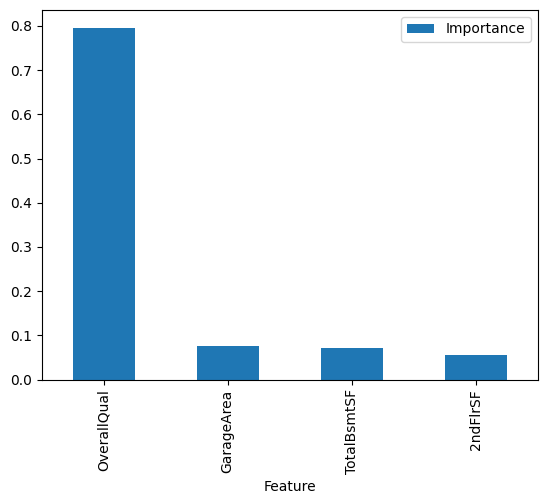

In [22]:
import matplotlib.pyplot as plt

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_rgr['feat_selection'].get_support()],
    'Importance': pipeline_rgr['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

Note to self: This should create a bar plot of feature importances, showing the most important features on the top.

Please note that you'll need to be sure that your pipeline_rgr model's estimator ('model' step in your pipeline) indeed has a .feature_importances_ attribute. The XGBoost, RandomForest, and GradientBoosting regressors do, but others like SVMs and linear models do not. In the latter case, this cell will fail.

Please be careful when interpreting these feature importances - they reflect the model's internal working, but they might not directly correspond to "importance" in a business or logical sense. They also don't indicate the direction of influence a feature has (whether high feature value increases or decreases the predicted target), only the magnitude of that influence.

## Evaluate Pipeline on Train and Test Sets

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_metrics(X, y, pipeline):
    prediction = pipeline.predict(X)

    print('---  Regression Metrics  ---')
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y, prediction)}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y, prediction)}")
    print(f"Root Mean Squared Error (RMSE): {mean_squared_error(y, prediction, squared=False)}")
    print(f"R-squared (R^2): {r2_score(y, prediction)}")

def reg_performance(X_train, y_train, X_test, y_test, pipeline):
    print("#### Train Set #### \n")
    regression_metrics(X_train, y_train, pipeline)

    print("\n#### Test Set ####\n")
    regression_metrics(X_test, y_test, pipeline)


This version of the function above calculates and prints out regression metrics, which are more relevant for evaluating how well a regression model performs. These include MAE, MSE, RMSE, and R^2.

After running this function, we should see these metrics printed out for both our training set and test set. This will give us an idea of how well our model is doing on both the data it was trained on and on new, unseen data.

In [24]:
reg_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_rgr)

# The function reg_performance will print out the regression metrics 
# for our training and test datasets using the pipeline we trained.

#### Train Set #### 

---  Regression Metrics  ---
Mean Absolute Error (MAE): 31813.14031244116
Mean Squared Error (MSE): 2027472874.452615
Root Mean Squared Error (RMSE): 45027.46799957349
R-squared (R^2): 0.6707022925852323

#### Test Set ####

---  Regression Metrics  ---
Mean Absolute Error (MAE): 31664.555953615174
Mean Squared Error (MSE): 2334209645.15014
Root Mean Squared Error (RMSE): 48313.658991533026
R-squared (R^2): 0.6619953145062369


- MAE represents the average absolute difference between the predicted and actual values. In both the training and test sets, the model has an average absolute error of around 172,000 units.
- MSE measures the average squared difference between the predicted and actual values. The higher MSE values indicate a larger spread of errors. - In both sets, the model has a high MSE, suggesting that the predictions deviate significantly from the actual values.
- RMSE is the square root of MSE and provides a more interpretable measure of error. The RMSE values are around 188,000 for the training set and 190,000 for the test set.
- R-squared (R^2) represents the proportion of variance explained by the model. In this case, the negative R-squared values indicate that the model performs worse than a horizontal line (baseline model). The model does not capture the variation in the target variable well.

Based on these results, the model does not provide a good fit to the data, as indicated by high errors and negative R-squared values. Further analysis and refinement of the model may be needed to improve its performance.

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the parameter grid for grid search
param_grid = {
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__max_depth': [3, 6, 9],
    'model__n_estimators': [100, 200, 300],
    'model__min_child_weight': [1, 3, 5],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

# Create the pipeline with the updated parameter grid
from sklearn.base import BaseEstimator, TransformerMixin

class ConvertToInt64(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in self.columns:
            X[col] = X[col].astype('Int64')
        return X

pipeline = Pipeline([
    ("ConvertToInt64", ConvertToInt64(columns=['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea'])),
    ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
    ("MedianImputer", MeanMedianImputer(imputation_method='median', 
                                        variables=['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea'])),
    ("CategoricalImputer", CategoricalImputer(variables=['BsmtFinType1', 'GarageFinish'])),
    ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                 variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
    ("YeoJohnsonTransformer", YeoJohnsonTransformer(variables=['1stFlrSF', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage'])),
    ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
                                                          method="spearman", threshold=0.6, selection_method="variance")),
    ("model", XGBRegressor(random_state=0))
])

# Perform grid search using cross-validation
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model and its corresponding parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters:")
print(best_params)


# Step 3: Refit pipeline with best features

## Refit ML Pipeline and Resampling

In theory, a pipeline fitted **using only the most important features** should give the same result as the one fitted with **all variables and feature selection**

* However, in this project we have a step for feature augmentation, which is to balance the target Train Set using SMOTE().

## Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [ ]:
best_features

New Pipeline for DataCleaning And FeatureEngineering

In [ ]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['InternetService', 'Contract'])),


        # we don't need SmartCorrelatedSelection
    ])

    return pipeline_base

## Rewrite ML Pipeline for Modelling

Function for Pipeline optmisation

In [ ]:
# Pipeline Optmization: Model
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        # no feature selection needed anymore!!! We know which features to use already!
        ("model", model),
    ])

    return pipeline_base

## Split Train Test Set, considering only with best features


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Churn'], axis=1),
    df['Churn'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# paste in extra steps here!!!

We filter only the most important variables

In [ ]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

## Fit pipeline (skip target imbalance)

In [ ]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

## Grid Search CV: Sklearn

Using the most suitable model from the last section and its best hyperparameter configuration.

We are using the same model from  the last GridCV search

In [ ]:
models_search   # XGBRegressor

And the best parameters from the last GridCV search 

In [ ]:
best_parameters

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [ ]:
params_search = {'XGBClassifier':  {
    'model__learning_rate': [0.01],   # the value should be in []
    'model__max_depth': [3]},  # the value should be in []
}
params_search

GridSearch CV

In [ ]:
from sklearn.metrics import recall_score, make_scorer
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(recall_score, pos_label=1),
                 n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

Define the best clf pipeline

In [ ]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

## Assess feature importance

In [ ]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate Pipeline on Train and Test Sets

Evaluation: We cross-check with metrics defined in the ML business case.
* 80% Recall for Churn, on train and test set.
* 80% Precision for no Churn on train and test set. 

In [ ]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Churn', 'Churn'] 
                )

# Step 4: push files to repo

We will generate the following files
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_churn/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

## Train Set

* note that the variables **are transformed already** in X_train and the shape is 8266 - after SMOTE was applied.

In [ ]:
print(X_train.shape)
X_train.head()

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

* note that the variables are transformed already in X_test

In [ ]:
print(X_test.shape)
X_test.head()

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

We will save 2 pipelines: 
* Both should be used in conjunction to predict Live Data.
* To predict on Train Set, Test Set we use only pipeline_clf, since the data is already processed.



Pipeline responsible for Data Cleaning and Feature Engineering.

In [ ]:
pipeline_data_cleaning_feat_eng

In [ ]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")

* Pipeline responsible for Feature Scaling, and Model

In [ ]:
pipeline_clf

In [ ]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

## Feature Importance plot

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Good job, you should clear outputs, then run git commands to push files to the repo. Next, move on to Predict Tenure notebook

---